In [ ]:
conda install numpy=1.26

In [ ]:
# ----- 1) Setup & Imports -----
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
)
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Reproducibility
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Jupyter inline display
%matplotlib inline

In [ ]:
# 2) Config & data paths 
data_dir_train = "COMBINEDATASETS"      
data_dir_test  = "COMBINEDATASETS"  

img_height = 128
img_width  = 128
batch_size = 32
color_mode = "rgb"  # use "grayscale" if single-channel ultrasound


In [ ]:
# 3) Load TRAIN/VAL (80/20 split from a single directory)
train_ds = image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    color_mode=color_mode,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.20,
    subset="training",
    seed=SEED,
    shuffle=True,
)

val_ds = image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    color_mode=color_mode,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.20,
    subset="validation",
    seed=SEED,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes ({num_classes}):", class_names)

# Data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)


In [41]:
# 4) Load TEST (separate folder)
# If you don't have a separate test folder yet, skip this cell or create COMBINEDATASETS_TEST/<class>...

test_ds = image_dataset_from_directory(
    data_dir_test,
    labels="inferred",
    label_mode="int",
    color_mode=color_mode,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)


Found 3050 files belonging to 3 classes.


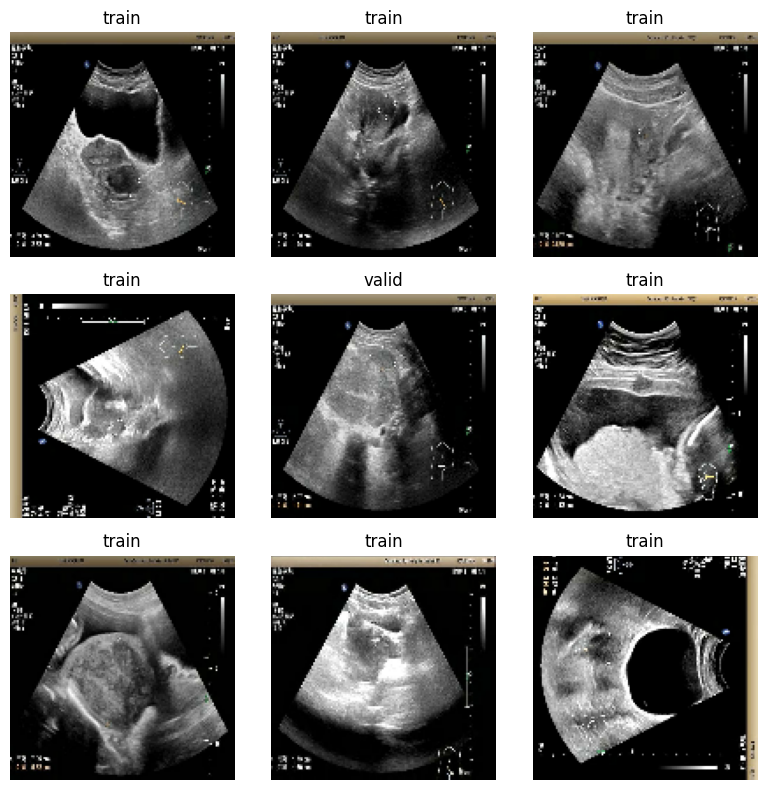

2025-11-15 14:17:06.595816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
# 5) Quick preview (first batch of train)
for images, labels in train_ds.take(1):
    plt.figure(figsize=(8, 8))
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [23]:
# 6) Simple CNN
in_channels = 3 if color_mode == "rgb" else 1
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, in_channels)),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,731 (6.22 MB)

 Trainable params: 1,629,731 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# 7) Train
EPOCHS = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9974 - loss: 0.0148 - val_accuracy: 0.9787 - val_loss: 0.1675
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9972 - loss: 0.0118 - val_accuracy: 0.9820 - val_loss: 0.1769
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9992 - loss: 0.0051 - val_accuracy: 0.9803 - val_loss: 0.1679
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9869 - val_loss: 0.1324
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9820 - val_loss: 0.1740
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9986 - loss: 0.0050 - val_accuracy: 0.9820 - val_loss: 0.1850
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 0.9820 - val_loss: 0.1685
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9999 - loss: 7.7304e-04 - val_accu

In [47]:
# 8) Helper to plot ROC (binary or multi-class)
def plot_roc_curves(y_true, probs, class_names, title="ROC"):
    plt.figure(figsize=(7, 6))
    num_classes = probs.shape[1]
    if num_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right"); plt.grid(True); plt.show()



Validation Classification Report:
              precision    recall  f1-score   support

        test       0.00      0.00      0.00         0
       train       0.97      1.00      0.99       344
       valid       1.00      0.96      0.98       266

    accuracy                           0.98       610
   macro avg       0.66      0.65      0.66       610
weighted avg       0.99      0.98      0.98       610



2025-11-15 14:18:59.976418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


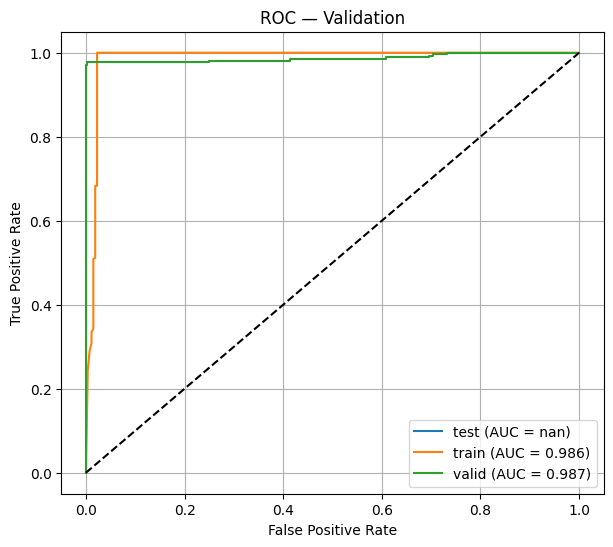

In [49]:
# 9) Validation metrics (report + ROC)
val_labels, val_probs = [], []
for x, y in val_ds:
    val_probs.append(model.predict(x, verbose=0))
    val_labels.append(y.numpy())
val_probs  = np.concatenate(val_probs, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

val_pred = np.argmax(val_probs, axis=1)
print("\nValidation Classification Report:")
print(classification_report(val_labels, val_pred,
                            labels=np.arange(len(class_names)),
                            target_names=class_names,
                            zero_division=0))

plot_roc_curves(val_labels, val_probs, class_names, title="ROC — Validation")


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9921 - loss: 0.1081
Test Loss: 0.0605
Test Accuracy: 0.9944

Test Classification Report:
              precision    recall  f1-score   support

        test       0.98      0.95      0.97       132
       train       0.99      1.00      1.00      2652
       valid       1.00      0.96      0.98       266

    accuracy                           0.99      3050
   macro avg       0.99      0.97      0.98      3050
weighted avg       0.99      0.99      0.99      3050



2025-11-15 14:19:16.879574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


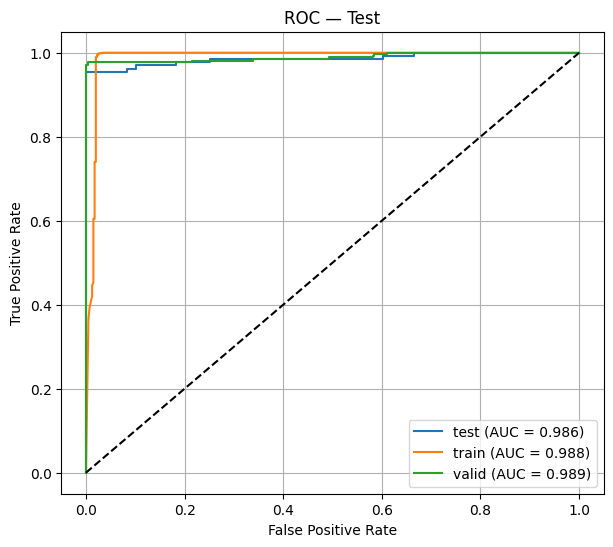

In [51]:
# 10) TEST evaluation (loss/acc), report, ROC
# Skip if you don't have a test set directory

test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

test_labels, test_probs = [], []
for x, y in test_ds:
    test_probs.append(model.predict(x, verbose=0))
    test_labels.append(y.numpy())

test_probs  = np.concatenate(test_probs, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

test_pred = np.argmax(test_probs, axis=1)
print("\nTest Classification Report:")
print(classification_report(test_labels, test_pred,
                            labels=np.arange(len(class_names)),
                            target_names=class_names,
                            zero_division=0))

plot_roc_curves(test_labels, test_probs, class_names, title="ROC — Test")


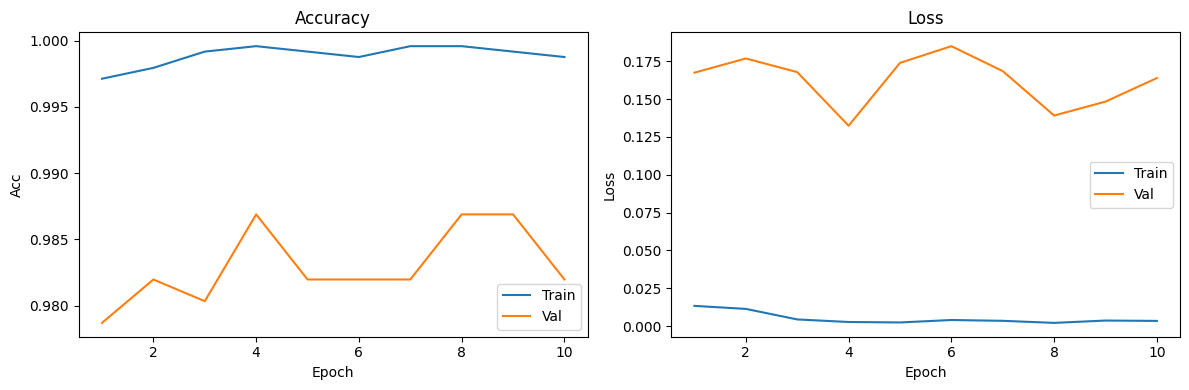

In [53]:
# 11) Training curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(acc)+1), acc, label='Train')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Val')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(loss)+1), loss, label='Train')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout(); plt.show()
